# Magnetostatic examples (2D)


## 1) Equations
Let us consider the following Maxwell's equations on a 3D domain $\Omega$:

$$
\left \{
\begin{array}{ll}
\underline{\text{curl}}~ \underline{h} = \underline{j} & \text{(Maxwell-Ampère),} \\
\text{div}~ \underline{b}  = 0 & \text{(Maxwell-Thomson),} 
\end{array} \right.
$$

where $\underline{h}$ is the magnetic field ($A/m$), $\underline{j}$ the current density ($A/m^2$) and $\underline{b}$ the flux density ($T$). The Maxwell-Thomson equation can be strongly ensured by defining a vector potential $\underline{a}$, such that 

$$ \underline{b} = \underline{\text{curl}}~\underline{a}. $$

Assuming all materials to be linear, isotropic and non-polarized, the behavior law reads

$$ \underline{h} = \nu ~ \underline{b}, $$

with $\nu = \mu^{-1}$ as the scalar magnetic reluctivity. By injecting these two relations into Maxwell-Ampère equations, one obtains the following primal (or B-conform) magnetostatic equation:  
 
 $$\underline{\text{curl}}~ (\nu ~ \underline{\text{curl}}~\underline{a}) = \underline{j}.$$
 
Taking any test function $\underline{a}^*$ in a certain space $H_{\text{curl}}(\Omega) = \{ a\in L^2(\Omega), \text{curl}~a \in L^2(\Omega) \}$ where the curl operator can be applied. The weak form of this equation reads

 $$ \forall \underline{a}^*\in H_{\text{curl}}(\Omega), \quad \int_\Omega \underline{a}^* \cdot \underline{\text{curl}}~ (\nu ~ \underline{\text{curl}}~\underline{a}) = \int_\Omega \underline{a}^* \cdot \underline{j}$$
 
 By integrating by part, *i.e.* by using:
  - first the Leibniz formula $ \underline{A} \cdot \underline{\text{curl}}~ \underline{B} = \underline{B} \cdot \underline{\text{curl}}~ \underline{A} - \text{div}~(\underline{A} \times \underline{B}) $,
  - then the Green-Ostrogradski formula $\int_\Omega \text{div}~(\underline{A} \times \underline{B}) =  \int_{\partial \Omega} (\underline{A} \times \underline{B}) \cdot \underline{n}$,
 
we obtain after some manipulations:
 $$  \forall \underline{a}^*\in H_{\text{curl}}(\Omega), \quad\int_\Omega \underline{\text{curl}}~\underline{a}^* \cdot (\nu~\underline{\text{curl}}~\underline{a}) - \int_{\partial \Omega} \underline{a}^* \cdot ((\nu~\underline{\text{curl}}~\underline{a} )\times \underline{n}) = \int_\Omega \underline{a}^* \cdot \underline{j}$$
 
Assuming the boundary term equal to 0, the weak form reads:

 $$ \boxed{  \forall \underline{a}^*\in H_{\text{curl}}(\Omega), \quad \int_\Omega \underline{\text{curl}}~\underline{a}^* \cdot (\nu~\underline{\text{curl}}~\underline{a}) = \int_\Omega \underline{a}^* \cdot \underline{j}}$$

Even with appropriate boundary conditions, the solution $a$ of this equation is not unique : indeed, for any $\psi$ such as $\nabla \psi=0$ on $\partial \Omega$, $a+\nabla \psi$ is still a solution. Therefore, there are three possibilities to solve the problem:
1. Add a small **penalized mass term**, so that the problem is not singular anymore but is (a little bit) perturbed
2. Solve the problem with an **iterative method**, where $\psi$ is fixed from the initial guess ; however, the right hand side should remain compatible
3. Add a **constraint (gauging)**, so that the problem is not singular anymore. 

In this example a 2D case is addressed.

## 2) Geometry

The geometry includes an iron wire inside a cylindrical coil. The current density is in the $x-y$ plane, and the flux is in the orthogonal $z$ direction.

In [1]:
from ngcotree import *
from geometries import *
from ngsolve import *
from ngsolve.webgui import Draw

geo = magneticWire()
mesh = Mesh(geo.GenerateMesh(maxh = 2e-3))
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

## 3) Physical properties 

In [2]:
mu0 = 4e-7*pi
mur = 1000 
J = 1e5 # A/m^2
nu = mesh.MaterialCF({"iron" : 1/(mu0 * mur)}, default = 1/mu0)
j = J * mesh.MaterialCF({"copper" : (-y/(sqrt(x**2 + y**2)), x/(sqrt(x**2 + y**2)))}, default = (0,0))

print("Reluctivity")
Draw(nu, mesh)

print("Current density")
Draw(j, mesh, vectors = {})

Reluctivity


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Current density


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

## 4) Resolution
### 4a) Penalization

Adding a small mass term create a small and controlled error, but also regularizes the system. However, it is still required to solve the problem on all the edges.

In [3]:
def SolvePenal(mesh, nu, j , epsilon = 1e-6, order = 0):
    fes = HCurl(mesh, order = order)
    a, aStar = fes.TnT()
    
    bf = BilinearForm( curl(aStar) * (nu * curl(a)) * dx)
    bf += epsilon * aStar * nu * a * dx  # Penalization
    lf = LinearForm( aStar * j * dx )
    
    bf.Assemble()
    lf.Assemble()
    
    fd=fes.FreeDofs()
    fd[0] = 0
    
    aSol = GridFunction(fes)
    aSol.vec.data += bf.mat.Inverse(freedofs=fd, inverse = "sparsecholesky") * lf.vec
    return aSol

print("Result of the non-penalized problem using a direct solver")
aPen0 = SolvePenal(mesh, nu, j, epsilon = 0)
Draw(curl(aPen0), mesh)

print("Result of the penalized problem using a direct solver")
aPen1 = SolvePenal(mesh, nu, j, epsilon = 1e-6)
Draw(curl(aPen1), mesh)

Result of the non-penalized problem using a direct solver


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Result of the penalized problem using a direct solver


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

### 4b) Iterative solver and RHS compatibility

One can of course solve the penalized problem with an iterative solver. It is however possible to solve the unpenalized problem as well, providing that the RHS is in Hcurl; that is to say, the current density should be written as $\text{curl}~\mathbf{t}$, so an auxiliary problem should be solved to reach convergence.

In [4]:
from ngsolve.krylovspace import CGSolver

def curlH1(a): # curl becomes grad with a rotation in this case
    return CF(((0,1),(-1,0)), dims = (2,2)) * grad(a)

def AuxiliaryProblemJ2T(mesh, j, order = 0):
    
    fes = H1(mesh, order = order, dirichlet = "out")
    t, tStar = fes.TnT()
    
    bf = BilinearForm( curlH1(tStar) * curlH1(t) * dx)
    lf = LinearForm(  curlH1(tStar) * j * dx )       # compatible RHS because of the curl(tStar)
    c = Preconditioner(bf, "local")

    bf.Assemble()
    lf.Assemble()
   
    tSol = GridFunction(fes)
    
    iterativeSolver = CGSolver(bf.mat, c.mat, atol = 1e-10, maxiter = 1000)
    tSol.vec.data = iterativeSolver * lf.vec
    print(f"Number of iterations = {iterativeSolver.iterations}/1000 | Residual = {iterativeSolver.residuals[-1]:.2e} /1e-10 ")
    return tSol

print("Projected current density")
t = AuxiliaryProblemJ2T(mesh, j)
Draw(curlH1(t), mesh, vectors = {})
print("log(Norm of projected current density)")
Draw(log(Norm(curlH1(t))), mesh, vectors = {})

Projected current density
Number of iterations = 148/1000 | Residual = 8.28e-11 /1e-10 


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

log(Norm of projected current density)


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [5]:
def SolveCG(mesh, nu, j , order = 0):
    fes = HCurl(mesh, order = order)
    a, aStar = fes.TnT()
    
    bf = BilinearForm( curl(aStar) * (nu * curl(a)) * dx )
    lf = LinearForm( aStar * j * dx )
    c = Preconditioner(bf, "local")
    
    fd=fes.FreeDofs()
    #fd[0] = 0

    bf.Assemble()
    lf.Assemble()

    iterativeSolver = CGSolver(bf.mat, c.mat, atol = 1e-10,  maxiter  = 1000, printrates = False)
    
    aSol = GridFunction(fes)
    aSol.vec.data =  iterativeSolver * lf.vec
    print(f"Number of iterations = {iterativeSolver.iterations}/1000 | Residual = {iterativeSolver.residuals[-1]:.2e} /1e-10 ")
    return aSol

print("Result of the non compatible RHS with CG (non convergence)")
aCG0 = SolveCG(mesh, nu, j) # the minimum residual error is due to the inexact compatibility of the RHS, and then diverges due to numerical errors if CG is not stopped
Draw(curl(aCG0), mesh)

print("Result of compatible RHS using CG")
aCG1 = SolveCG(mesh, nu, curlH1(t)) # the method converges, but the solution is associated to curl(t) and not the original j
Draw(curl(aCG1), mesh)

Result of the non compatible RHS with CG (non convergence)
Number of iterations = 1000/1000 | Residual = 3.66e+00 /1e-10 


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Result of compatible RHS using CG
Number of iterations = 221/1000 | Residual = 9.94e-11 /1e-10 


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

## 4c) Tree/cotree gauging
On the discrete level, one can remove the gradient space, which is dimension $N-1$ ($N$ being the number of basis functions associated to the nodes, with the constant function removed). So we should remove exactly $N-1$ dofs, without creating cycles that would isolate a part of the mesh from the rest. One can therefore see this process to an identification of exactly one edge to one vertex, which is the definition of a tree, that should be removed. This technique was introduced by Albanese & Rubinacci (1988), and some other types of gauging exist, see https://www.compumag.org/jsite/images/stories/newsletter/ICS-02-09-1-Munteanu.pdf)

The advantages are that the dimension of the space is reduced, there is no penalization, it needs only to build a tree (which is fast, the complexity is $N\log N$) and does not need to solve any other auxiliary problem, and enables the use of direct solver.

Built tree


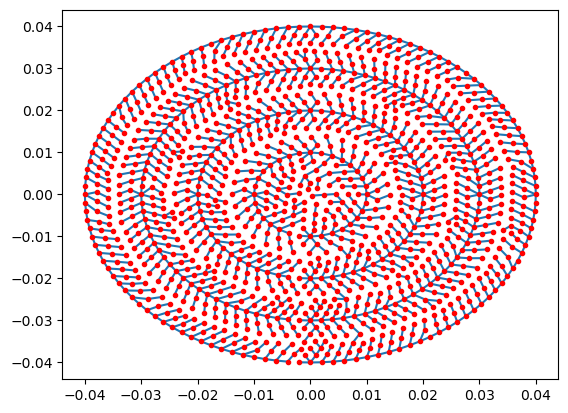

Solution obtained with a tree-cotree gauging


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [6]:
from ngcotree import *

def SolveTreeCoTree(mesh, nu, j , order = 0):
    fes = HCurl(mesh, order = order)
    a, aStar = fes.TnT()

    bf = BilinearForm( curl(aStar) * (nu * curl(a)) * dx )
    lf = LinearForm( aStar * j * dx )
    c = Preconditioner(bf, "local")

    fd = CoTreeBitArray(mesh, fes, plot = True)
    
    bf.Assemble()
    lf.Assemble()
    
    aSol = GridFunction(fes)
    aSol.vec.data += bf.mat.Inverse(freedofs=fd, inverse = "sparsecholesky") * lf.vec
    return aSol

print("Built tree")
aCotree = SolveTreeCoTree(mesh, nu, j)
print("Solution obtained with a tree-cotree gauging")
Draw(curl(aCotree), mesh)